In [1]:
import subprocess

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
base_cmd = (
    "glm_benchmarks_run --threads 6 --num_rows {n} --storage {s} "
    "--problem_name {p} --library_name {lib}"
)

size = "intermediate"
problems = [
    f"{size}-insurance-no-weights-lasso-tweedie-p=1.5",
    f"{size}-insurance-no-weights-lasso-poisson",
    f"{size}-insurance-no-weights-lasso-gaussian",
    f"{size}-insurance-no-weights-lasso-gamma",
    f"{size}-insurance-no-weights-lasso-binomial",
    f"{size}-insurance-no-weights-l2-tweedie-p=1.5",
    f"{size}-insurance-no-weights-l2-poisson",
    f"{size}-insurance-no-weights-l2-gaussian",
    f"{size}-insurance-no-weights-l2-gamma",
    f"{size}-insurance-no-weights-l2-binomial",
]

libraries = ["quantcore-glm", "r-glmnet", "h2o"]

n = 500000

# run r-glmnet and h2o benchmarks, sparse storage works best.
s = "sparse"
for lib in ["r-glmnet", "h2o"]:
    for p in problems:
        cmd = base_cmd.format(n=n, s=s, p=p, lib=lib)
        print(cmd)
        subprocess.run(cmd.split(" "))

# run quantcore-glm benchmarks where auto storage works best.
lib = "quantcore-glm"
s = "auto"
for p in problems:
    cmd = base_cmd.format(n=n, s=s, p=p, lib=lib)
    print(cmd)
    subprocess.run(cmd.split(" "))

analyze_cmd = "glm_benchmarks_analyze --export benchmark_data.csv"
subprocess.run(analyze_cmd.split(" "))

glm_benchmarks_run --threads 6 --num_rows 500000 --storage sparse --problem_name intermediate-insurance-no-weights-lasso-binomial --library_name r-glmnet
running problem=intermediate-insurance-no-weights-lasso-binomial library=r-glmnet


R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.1-2



ran problem intermediate-insurance-no-weights-lasso-binomial with library r-glmnet
ran in 0.7055881023406982
glm_benchmarks_run --threads 6 --num_rows 500000 --storage sparse --problem_name intermediate-insurance-no-weights-l2-binomial --library_name r-glmnet
running problem=intermediate-insurance-no-weights-l2-binomial library=r-glmnet


R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.1-2



ran problem intermediate-insurance-no-weights-l2-binomial with library r-glmnet
ran in 0.9344775676727295
glm_benchmarks_run --threads 6 --num_rows 500000 --storage sparse --problem_name intermediate-insurance-no-weights-lasso-binomial --library_name h2o
running problem=intermediate-insurance-no-weights-lasso-binomial library=h2o
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1-internal" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1-internal+0-adhoc..src); OpenJDK 64-Bit Server VM (build 11.0.9.1-internal+0-adhoc..src, mixed mode)
  Starting server from /home/tbent/.miniconda3/envs/quantcore.glm/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpshej47qx
  JVM stdout: /tmp/tmpshej47qx/h2o_tbent_started_from_python.out
  JVM stderr: /tmp/tmpshej47qx/h2o_tbent_started_from_python.err
  Server is running at http://127.0.0.1:54321
Co

CompletedProcess(args=['glm_benchmarks_analyze', '--export', 'benchmark_data.csv'], returncode=0)

In [17]:
df = pd.read_csv("benchmark_data.csv")
df.drop(
    [
        "storage",
        "num_rows",
        "regularization_strength",
        "offset",
        "threads",
        "single_precision",
        "cv",
        "hessian_approx",
        "diagnostics_level",
    ],
    axis=1,
    inplace=True,
)
df["distribution"] = (
    df["problem_name"].str.split("-").apply(lambda x: x[-2] if "5" in x[-1] else x[-1])
)

In [18]:
%config InlineBackend.figure_format='retina'

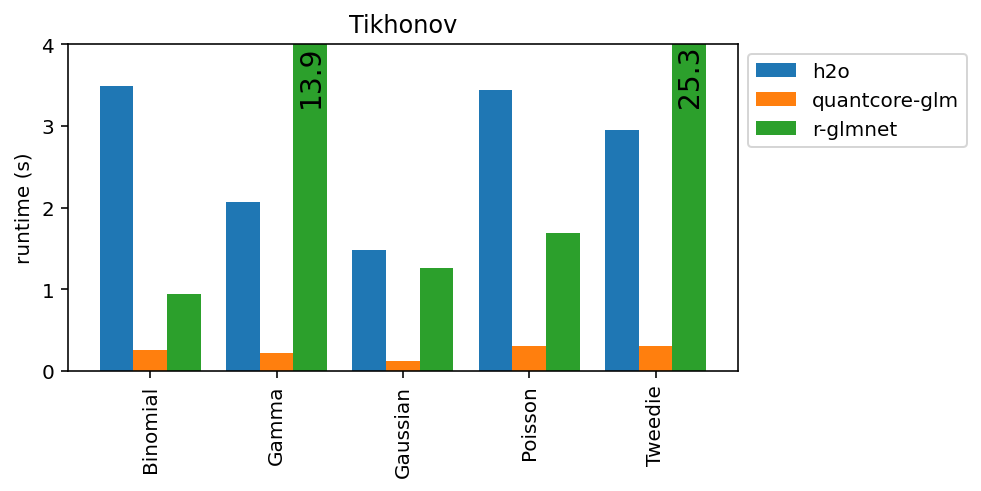

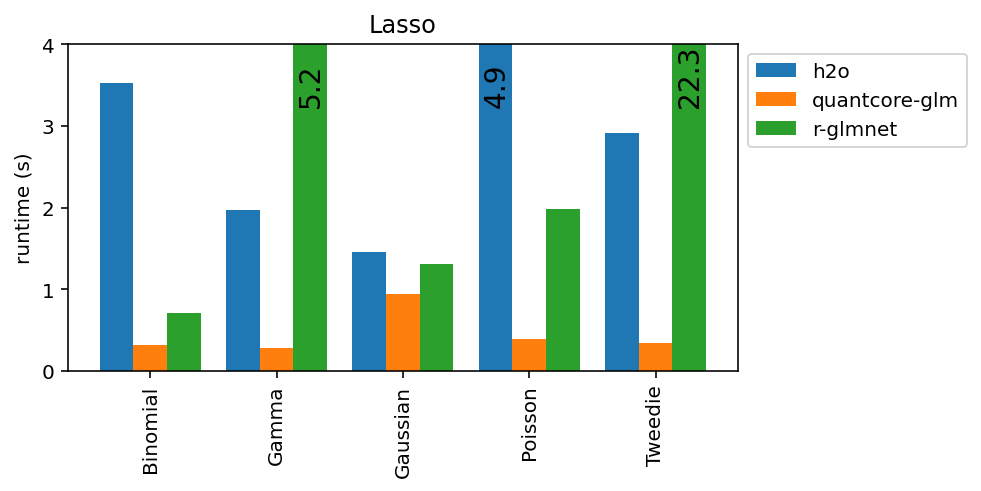

In [25]:
for width in ["intermediate"]:#"narrow", "intermediate"]:
    for reg in ["l2", "lasso"]:
        plot_df = (
            df[df["problem_name"].str.contains(reg) & df['problem_name'].str.contains(width)]
            .copy()
            .set_index(["distribution"])[["runtime", "library_name"]]
        )
        plot_df = plot_df.pivot(columns="library_name")
        plot_df.columns = plot_df.columns.get_level_values(1)
        plot_df.index = [x[0:1].upper() + x[1:] for x in plot_df.index]

        reg_title = "Lasso" if reg == "lasso" else "Tikhonov"
        plot_df.plot.bar(
            ylim=[0, 4],
            title=reg_title,
            legend=False,
            figsize=(6, 3),
            width=0.8,
            ylabel="runtime (s)",
            yticks=[0, 1, 2, 3, 4]
        )
        plt.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=1)
        ax = plt.gca()
        for p in ax.patches:
            x = p.get_x()  # type: ignore
            y = p.get_height()  # type: ignore
            if y > 3.6:
                plot_y = 3.3
                ax.annotate(
                    f"{y:.1f}",
                    (x + 0.03, plot_y),
                    fontsize=14,
                    rotation="vertical",
                )
        plt.show()